<a href="https://colab.research.google.com/github/Jeremy26/3d-deep-learning/blob/main/1_YOLO_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the YOLO Workshop!

In this workshop, we will learn how to use the YOLO algorithm for object detection

Import the YOLO files and the images

In [ ]:
!wget https://thinkautonomous-tracking.s3.eu-west-3.amazonaws.com/tracking_course.zip && unzip tracking_course.zip

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import copy

## Read an Image

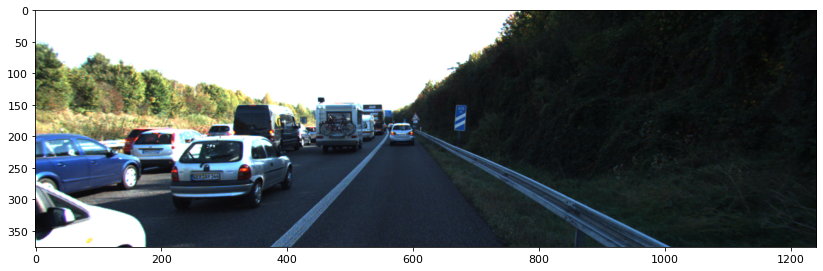

In [18]:
img = cv2.cvtColor(cv2.imread("tracking_course/data/0000000230.png"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14,7))
plt.imshow(img)
plt.show()

## YOLOv5

In [131]:
!pip install yolo5 # version 0.0.1 used at the moment of recording

ERROR: Invalid requirement: '=='


In [10]:
import yolov5

# load model
model = yolov5.load('tracking_course/yolov5s.pt')

image = copy.deepcopy(img)
results = model(image)

In [11]:
predictions = results.pred[0]

boxes = predictions[:, :4].tolist()
scores = predictions[:,4].tolist()
categories = predictions[:,5].tolist()

print(boxes)
print(scores)
print(categories)

[[0.0, 192.24169921875, 167.97128295898438, 293.19415283203125], [559.4194946289062, 178.3046875, 602.0789184570312, 212.72305297851562], [212.56971740722656, 195.15029907226562, 408.8998107910156, 318.1595764160156], [133.5529327392578, 185.3337860107422, 265.8939514160156, 260.95721435546875], [312.91619873046875, 149.4611358642578, 421.98846435546875, 230.4169921875], [442.8334045410156, 143.1591796875, 541.9679565429688, 225.8117218017578], [0.0, 258.53338623046875, 177.9089813232422, 375.3619079589844]]
[0.85888671875, 0.80078125, 0.7880859375, 0.75146484375, 0.6669921875, 0.6474609375, 0.56201171875]
[2.0, 2.0, 2.0, 2.0, 7.0, 7.0, 2.0]


**Note ——** We are currently running YOLOv5 and therefore benefit having the boxes in format (x1, y1, x2, y2). <p>
--> If we were using YOLOv4 (pip install yolov4), we'd have the boxes in format (center_x, center_y, w, h) and every number would be a ratio between 0 and 1. <p>
Although YOLOv5 makes our life simpler, it's good to note what would be needed in case we were using YOLOv4:

* A function to convert the boxes
```python
def convert_box(center_x, center_y, width, height):
    left = int(center_x - width/2)
    right = int(center_x + width/2)
    top = int(center_y - height/2)
    bottom = int(center_y + height/2)
    return left, top, right, bottom
```

* A function call to get the output
```python
# Run YOLOv4
def run_obstacle_detection(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = yolo.resize_image(img)
    resized_image = resized_image / 255. # 0 ~ 255 to 0.0 ~ 1.0
    input_data = resized_image[np.newaxis, ...].astype(np.float32)
    candidates = yolo.model.predict(input_data)
    _candidates = []
    result = img.copy()
    for candidate in candidates:
        batch_size = candidate.shape[0]
        grid_size = candidate.shape[1]
        _candidates.append(tf.reshape(candidate, shape=(1, grid_size * grid_size * 3, -1)))
        candidates = np.concatenate(_candidates, axis=1)
        pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0], iou_threshold=0.35, score_threshold=0.50)
        pred_bboxes = pred_bboxes[~(pred_bboxes==0).all(1)] #https://stackoverflow.com/questions/35673095/python-how-to-eliminate-all-the-zero-rows-from-a-matrix-in-numpy?lq=1
        pred_bboxes = yolo.fit_pred_bboxes_to_original(pred_bboxes, img.shape)
        result = yolo.draw_bboxes(img, pred_bboxes)
    return result, pred_bboxes
# Then Call It
result, pred_bboxes = run_obstacle_detection(img)
```

```python
h, w, _ = img.shape
box = pred_bboxes[0] # Take a Box
print("Output: ", box)
```
```
Output: [0.07116244 0.86740445 0.14166754 0.3738073  2.  0.80694628]
```
From here, we would gave to convert back to the right format:
```python
print("center_x:",testing_box[0]*w)
print("center_y",testing_box[1]*h)
print("width:", testing_box[2]*w)
print("height:",testing_box[3]*h)
print("class:", classes[int(testing_box[4])])
print("confidence:", testing_box[5])
```
```
original box [0.07116244 0.86740445 0.14166754 0.3738073  2.         0.80694628]
center_x: 88.3125878944993
center_y 326.14407497644424
width: 175.80942314863205
height: 140.55154662579298
class: car
confidence: 0.8069462776184082
```

This isn't a mandatory thing, but realize that YOLOv5 makes our life WAY simpler; especially since our Association & Tracking code will directly be using the format (x1,y1,x2,y2).

In [33]:
def id_to_color(idx):
    """
    Random function to convert an id to a color
    Do what you want here but keep numbers below 255
    """
    blue = idx*5 % 256
    green = idx*12 %256
    red = idx*23 %256
    return (red, green, blue)

def draw_boxes_v5(image, boxes, categories, mot_mode=False):
    h, w, _ = image.shape
    for i, box in enumerate(boxes):
        label = classes[int(categories[i])]
        color = id_to_color(i*10) if mot_mode==True else (255,0,0)
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, thickness=7)
        cv2.putText(image, str(label), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=3)
    return image

In [31]:
classesFile = "tracking_course/coco.names"
with open(classesFile,'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

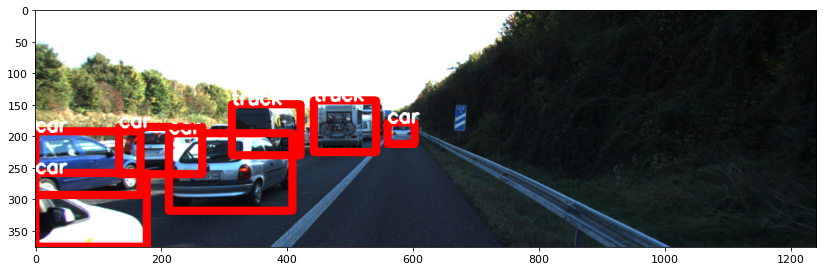

In [32]:
plt.figure(figsize=(14,7))
plt.imshow(draw_boxes_v5(img, boxes, categories,mot_mode=False))
plt.show()

### Create an Inference Function

In [35]:
def inference(img):
    results = model(img)
    predictions = results.pred[0]
    boxes = predictions[:, :4].tolist()
    scores = predictions[:,4].tolist()
    categories = predictions[:,5].tolist()
    img_out = draw_boxes_v5(img, boxes, categories, mot_mode=True)
    return img_out, boxes

## Run on a Video

In [114]:
import glob 
from tqdm import tqdm

video_images = sorted(glob.glob("tracking_course/data/*.png"))
result_video = []

for img in tqdm(video_images):
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    img_out, _ = inference(img)
    result_video.append(img_out)

100%|██████████| 837/837 [00:23<00:00, 35.00it/s]


In [115]:
out = cv2.VideoWriter('out_yolo.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (img.shape[1],img.shape[0]))

for img in result_video:
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()

In [104]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('out_yolo.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)